In [24]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import datetime
import pandas as pd
from scipy import stats

from palettable.colorbrewer.diverging import *
from palettable.colorbrewer.sequential import *
from calendar import monthrange

from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg

# Maps of 110 m - 70 m and 30 m - 70 m fetch lengths

In [25]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_WN/output/grids/a3d_grids_2015.nc"
ds_70 = xr.open_dataset(path)
n_trim = 15 # 15
ds_70 = ds_70.isel(easting=slice(n_trim, -n_trim))
ds_70 = ds_70.isel(northing=slice(n_trim, -n_trim))
smb70 = 1000 * (ds_70['swe'][-1,:,:] - ds_70['swe'][0,:,:])

In [26]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_110m/output/grids/a3d_grids_2015.nc"
ds_110 = xr.open_dataset(path)
n_trim = 15 # 15
ds_110 = ds_110.isel(easting=slice(n_trim, -n_trim))
ds_110 = ds_110.isel(northing=slice(n_trim, -n_trim))
smb110 = 1000 * (ds_110['swe'][-1,:,:] - ds_110['swe'][0,:,:])

In [27]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_30m/output/grids/a3d_grids_2015.nc"
ds_30 = xr.open_dataset(path)
n_trim = 15 # 15
ds_30 = ds_30.isel(easting=slice(n_trim, -n_trim))
ds_30 = ds_30.isel(northing=slice(n_trim, -n_trim))
smb30 = 1000 * (ds_30['swe'][-1,:,:] - ds_30['swe'][0,:,:])

In [28]:
smb_min = smb30.min()
smb_max = smb30.max()
max_magnitude = np.max([np.abs(smb_min), smb_max])

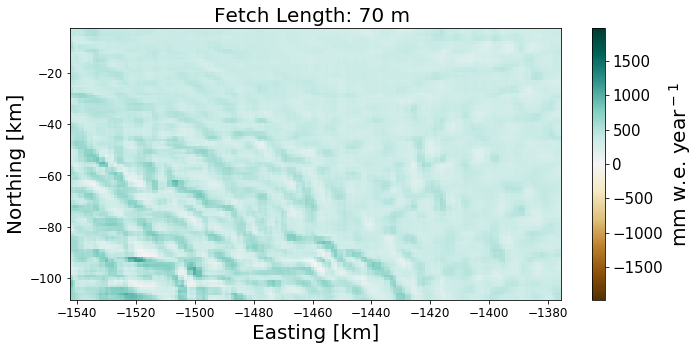

In [29]:
colormap = BrBG_11.mpl_colormap

plt.figure(figsize=(11, 5))
plt.pcolor(ds_70['easting']/1000, ds_70['northing']/1000, smb70, cmap=colormap, vmin=-max_magnitude, vmax=max_magnitude, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label("mm w.e. year$^-$$^1$", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Easting [km]", fontsize=20)
plt.ylabel("Northing [km]", fontsize=20)
plt.title("Fetch Length: 70 m ", fontsize=20)
plt.savefig("images/70.pdf", format='pdf', dpi=100, bbox_inches='tight')

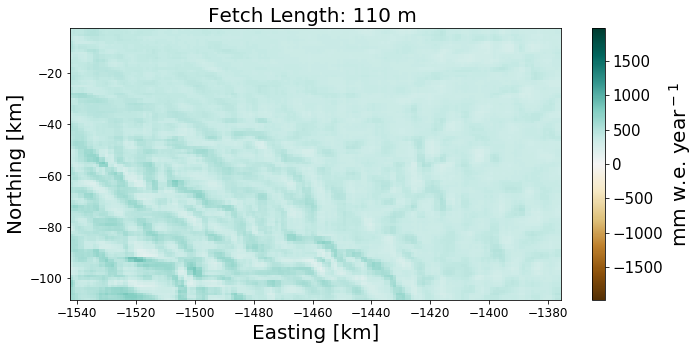

In [30]:
colormap = BrBG_11.mpl_colormap

plt.figure(figsize=(11, 5))
plt.pcolor(ds_70['easting']/1000, ds_70['northing']/1000, smb110, cmap=colormap, vmin=-max_magnitude, vmax=max_magnitude, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label("mm w.e. year$^-$$^1$", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Easting [km]", fontsize=20)
plt.ylabel("Northing [km]", fontsize=20)
plt.title("Fetch Length: 110 m ", fontsize=20)
plt.savefig("images/110.pdf", format='pdf', dpi=100, bbox_inches='tight')

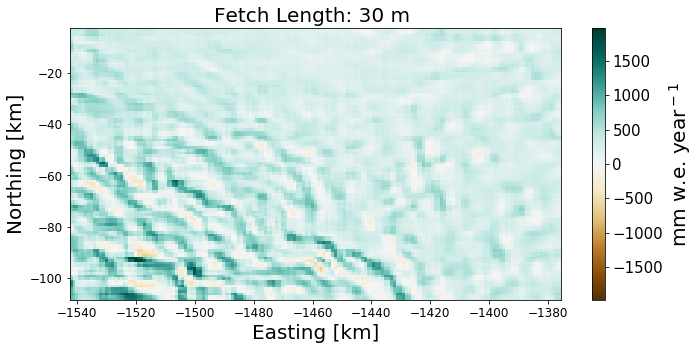

In [31]:
colormap = BrBG_11.mpl_colormap

plt.figure(figsize=(11, 5))
plt.pcolor(ds_70['easting']/1000, ds_70['northing']/1000, smb30, cmap=colormap, vmin=-max_magnitude, vmax=max_magnitude, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label("mm w.e. year$^-$$^1$", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Easting [km]", fontsize=20)
plt.ylabel("Northing [km]", fontsize=20)
plt.title("Fetch Length: 30 m ", fontsize=20)
plt.savefig("images/30.pdf", format='pdf', dpi=100, bbox_inches='tight')

# Transect

In [32]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

In [33]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

In [34]:
domain_left = ds_70['easting'].min()
domain_right = ds_70['easting'].max()
domain_bottom = ds_70['northing'].min()
domain_top = ds_70['northing'].max()

In [35]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    indices = filter_func(obsX, obsY)
    obs_accum_filter = obs_accum[indices]
    obsX_filter = obsX[indices]
    obsY_filter = obsY[indices]
    obs_lat_filter = obs_lat[indices]
    obs_lon_filter = obs_lon[indices]
    
    return obsX_filter, obsY_filter, obs_accum_filter, obs_lat_filter, obs_lon_filter

# # Retrieve observations
obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

In [36]:
tgt_x = xr.DataArray(obs_X, dims="points")
tgt_y = xr.DataArray(obs_Y, dims="points")

smb30_transect =  smb30.sel(northing=tgt_y, easting=tgt_x, method='nearest')
smb70_transect =  smb70.sel(northing=tgt_y, easting=tgt_x, method='nearest')
smb110_transect =  smb110.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# Indices to plot
ind0 = 660
indf = 2000
indices = np.arange(ind0, indf)

In [37]:
# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000

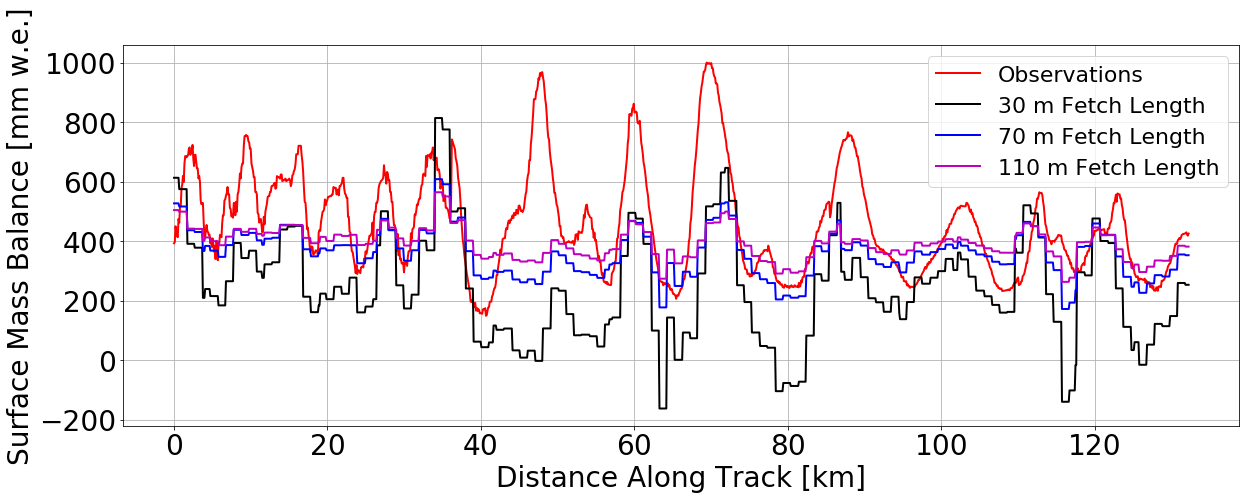

In [53]:
plt.figure(figsize=(20,7))
plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='Observations', linewidth=2)
plt.plot(dat, smb30_transect[indices], 'k', label='30 m Fetch Length', linewidth=2)
plt.plot(dat, smb70_transect[indices], 'b', label='70 m Fetch Length', linewidth=2)
plt.plot(dat, smb110_transect[indices], 'm', label='110 m Fetch Length', linewidth=2)

plt.grid()
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.ylabel("Surface Mass Balance [mm w.e.]", fontsize=28)
plt.xlabel("Distance Along Track [km]", fontsize=28)
plt.legend(fontsize=22)
plt.savefig('images/FL_transect.pdf', format='pdf', dpi=100)

# Print statistics

In [39]:
print(smb30.mean())
print(smb70.mean())
print(smb110.mean())

<xarray.DataArray 'swe' ()>
array(327.24194, dtype=float32)
<xarray.DataArray 'swe' ()>
array(393.8721, dtype=float32)
<xarray.DataArray 'swe' ()>
array(411.9045, dtype=float32)


<xarray.DataArray 'swe' ()>
array(0.04183356)

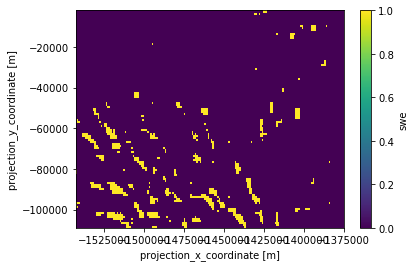

In [40]:
negative = smb30 < 0
negative.plot()
negative.mean()

# Scatter stats

In [41]:
spacing = 10
obs_convulation = 1000 * np.convolve(obs_accumulation[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
FL30_convulation = np.convolve(smb30_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
FL70_convulation = np.convolve(smb70_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
FL110_convulation = np.convolve(smb110_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]

In [42]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [43]:
x_1_to_1 = [-9999, 9999]
y_1_to_1 = [-9999, 9999]

p = 7.724872170158883e-12
R^2 = 0.2996056965283529
RMSE = 272.5516967898017
Average Bias = 229.50351649206434
Linear Fit Slope = 0.5512484378104054


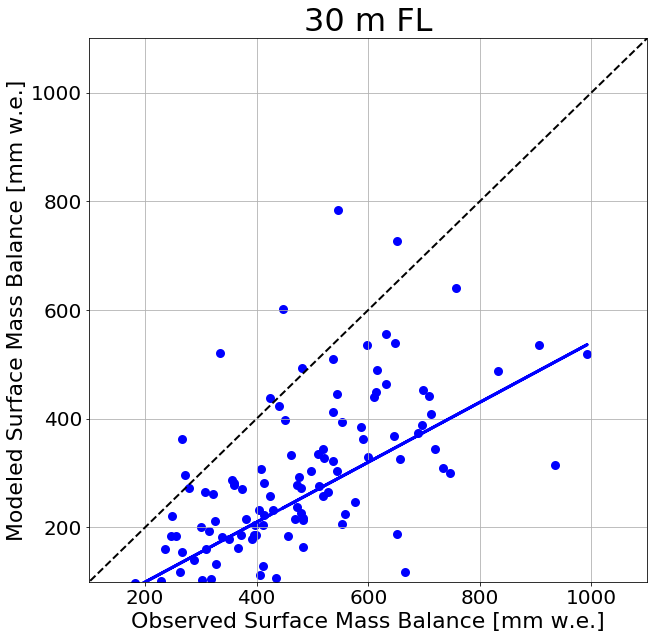

In [44]:
x = obs_convulation
y = FL30_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(10,10))
plt.scatter(x, y, c='b', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'b', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title("30 m FL", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=22)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=22)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))

p = 1.3823358999456603e-12
R^2 = 0.3173454526416262
RMSE = 175.20708127111038
Average Bias = 127.39662649960307
Linear Fit Slope = 0.2548986805263731


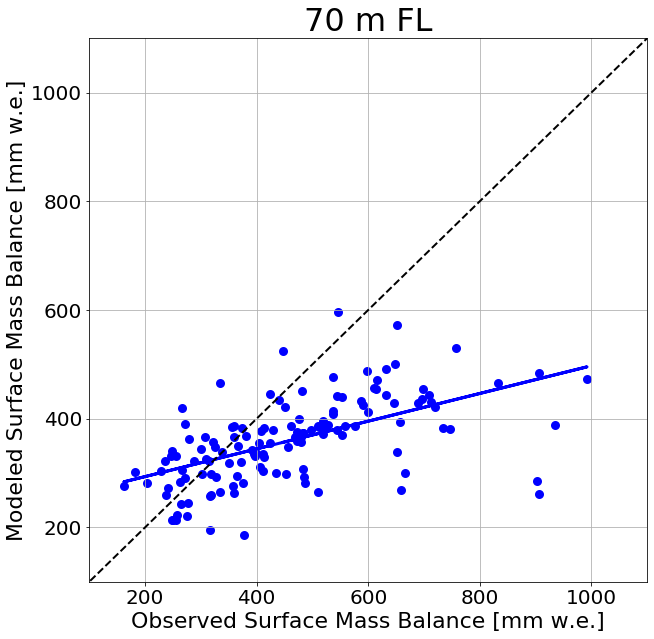

In [45]:
x = obs_convulation
y = FL70_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(10,10))
plt.scatter(x, y, c='b', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'b', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title("70 m FL", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=22)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=22)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))

p = 1.830660266367715e-12
R^2 = 0.3144788799683307
RMSE = 164.19034437088527
Average Bias = 118.57957892100605
Linear Fit Slope = 0.16728412690600128


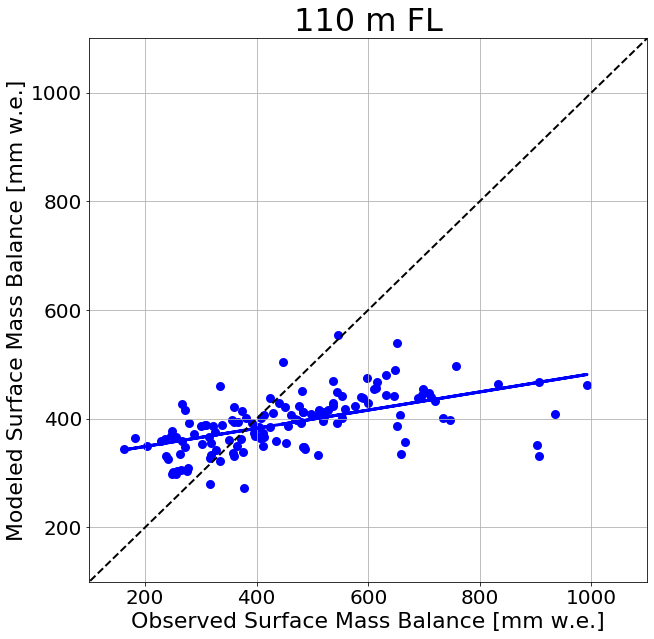

In [46]:
x = obs_convulation
y = FL110_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(10,10))
plt.scatter(x, y, c='b', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'b', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title("110 m FL", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=22)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=22)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))